In [1]:
import numpy as np
import os
import math
import pandas as pd
from tqdm import tqdm
import re

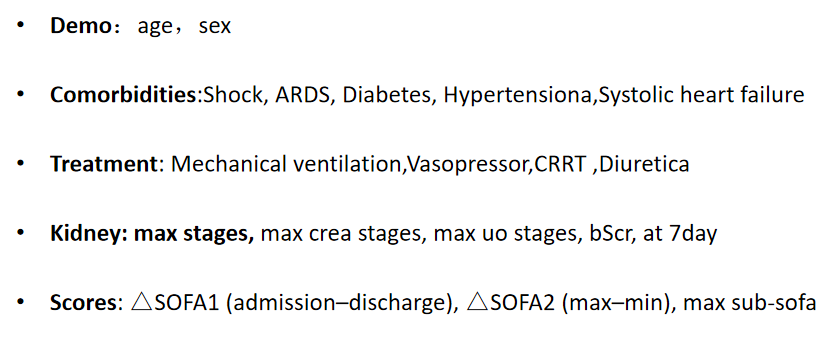

# MIMIC

In [ ]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/01.MIMICIV_SAKI_trajCluster/df_mixAK_fea4_C3.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("Number of included patients:",len(all_lst))

df_type_filt["groupHPD"].value_counts()

In [ ]:
df_demo = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/feature_data/df_mimic_basicinfo.csv")
df_demo = df_demo.loc[:,["stay_id",'gender', 'age']]  

# Add class tags
df_demo_base_add = pd.merge(df_type_filt, df_demo, how="left", on = "stay_id")
df_demo_base_add = df_demo_base_add.drop_duplicates()

# Mortality Rate
df_admit = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/01.MIMICIV_SAKI_trajCluster/sk_survival.csv")
df_admit = df_admit.loc[:,["stay_id", "mortality_28d","survival_28day"]]
df_demo_base_add = pd.merge(df_admit, df_demo_base_add, how="inner", on = "stay_id")

# Add baseline creatinine
df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/df_base_crea.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_base_crea, how="inner", on="stay_id")

# Add peak and discharge creatinine
df_peak_discharge = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/df_peak_discharge.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_peak_discharge, how="left", on="stay_id")

# Add the initial AKI and the highest-level AKI
df_sk_first_and_max_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_first_and_max_stage.csv")
df_sk_first_and_max_stage = df_sk_first_and_max_stage.loc[:,["stay_id","first_aki_stage", "max_aki_stage","aki_endstage","aki_endstage_H7D"]]
df_demo_base_add = pd.merge(df_sk_first_and_max_stage, df_demo_base_add, how="inner", on = "stay_id")

# Add the initial AKI and the highest-level AKI-CREA +uo
df_sk_first_and_max_stage_uc = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_first_and_max_stage_uo_crea.csv")
df_sk_first_and_max_stage_uc = df_sk_first_and_max_stage_uc.loc[:,["stay_id","max_aki_stage_crea","max_aki_stage_uo"]]
df_demo_base_add = pd.merge(df_sk_first_and_max_stage_uc, df_demo_base_add, how="inner", on = "stay_id")


# Add the SA-AKI type
df_event = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
df_event = df_event[df_event.stay_id.isin(all_lst)]
df_event["sepsis_onset"] = pd.to_datetime(df_event["sepsis_onset"])
df_event["saki_onset"] = pd.to_datetime(df_event["saki_onset"])
df_event["los_sepsis_saaki"] = (df_event["saki_onset"] - df_event["sepsis_onset"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
df_event.loc[df_event["los_sepsis_saaki"]<=48,"SA-AKI_type"] = "Early SA-AKI"
df_event.loc[df_event["los_sepsis_saaki"]>48,"SA-AKI_type"] = "Late SA-AKI"
df_event = df_event[['stay_id', 'los_sepsis_saaki','SA-AKI_type']]
df_demo_base_add = pd.merge(df_event, df_demo_base_add, how="inner", on = "stay_id")

# Comorbidity
df_icd = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//diag_icd/df_mimic_diag_icd.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_icd, how="left",on="stay_id")
df_demo_base_add[['Myocardial_infarct', 'Congestive_heart_failure',
       'Peripheral_vascular_disease', 'Cerebrovascular_disease',
       'Pulmonary(chronic)', 'Peptic_ulcer', 'Renal', 'Hepatic', 'Tumor',
       'Cardiovascular', 'Acidosis', 'Cardiogenic_shock', 'Diabetes',
       'Hypertension', 'Respiratory_failure', 'Septic_shock']] = df_demo_base_add[['Myocardial_infarct', 'Congestive_heart_failure',
       'Peripheral_vascular_disease', 'Cerebrovascular_disease',
       'Pulmonary(chronic)', 'Peptic_ulcer', 'Renal', 'Hepatic', 'Tumor',
       'Cardiovascular', 'Acidosis', 'Cardiogenic_shock', 'Diabetes',
       'Hypertension', 'Respiratory_failure', 'Septic_shock']].fillna(0)
df_demo_base_add[df_icd.columns.tolist()] = df_demo_base_add[df_icd.columns.tolist()].astype("int")

df_lifesupport = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/treatment/mimic_lifesupport.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_lifesupport, how="left", on = "stay_id")
df_demo_base_add.columns

Index(['stay_id', 'los_sepsis_saaki', 'SA-AKI_type', 'max_aki_stage_crea',
       'max_aki_stage_uo', 'first_aki_stage', 'max_aki_stage', 'aki_endstage',
       'aki_endstage_H7D', 'mortality_28d', 'survival_28day', 'groupHPD',
       'gender', 'age', 'baseline_Scr', 'Peak_Scr', 'Discharge_Scr',
       'Myocardial_infarct', 'Congestive_heart_failure',
       'Peripheral_vascular_disease', 'Cerebrovascular_disease',
       'Pulmonary(chronic)', 'Peptic_ulcer', 'Renal', 'Hepatic', 'Tumor',
       'Cardiovascular', 'Acidosis', 'Cardiogenic_shock', 'Diabetes',
       'Hypertension', 'Respiratory_failure', 'Septic_shock', 'is_vaso',
       'is_mv', 'is_rrt', 'is_crrt'],
      dtype='object')

## C1

In [4]:
df_mimic_c1 = df_demo_base_add[df_demo_base_add.groupHPD==1]
df_mimic_c1.to_csv("df_mimic_c1_riskfactor.csv",index=False)

## C2

In [5]:
df_mimic_c2 = df_demo_base_add[df_demo_base_add.groupHPD==2]
df_mimic_c2.to_csv("df_mimic_c2_riskfactor.csv",index=False)

## C3

In [6]:
df_mimic_c3 = df_demo_base_add[df_demo_base_add.groupHPD==3]
df_mimic_c3.to_csv("df_mimic_c3_riskfactor.csv",index=False)

# AUMC

In [ ]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/02.AUMCdb_SAKI_trajCluster/df_mixAK_fea3_C3_aumc.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("Number of included patients:",len(all_lst))

df_type_filt["groupHPD"].value_counts()

In [ ]:
df_demo = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/feature_data/df_aumc_basicinfo.csv")
df_demo = df_demo[['stay_id', 'icu_stay_days', 'gender', 'age', 'weight' ]]  

df_first_max_aki_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumc_first_and_max_stage.csv")
df_first_max_aki_stage = df_first_max_aki_stage[["stay_id","first_aki_stage","max_aki_stage","aki_endstage","aki_endstage_H7D"]]
df_demo = pd.merge(df_demo, df_first_max_aki_stage, how="left", on = "stay_id")

# Add the primary AKI and the highest-level AKI-CREA +uo
df_sk_first_and_max_stage_uc = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumc_sk_first_and_max_stage_uo_crea.csv")
df_sk_first_and_max_stage_uc = df_sk_first_and_max_stage_uc.loc[:,["stay_id","max_aki_stage_crea","max_aki_stage_uo"]]
df_demo = pd.merge(df_demo, df_sk_first_and_max_stage_uc, how="left", on = "stay_id")

df_lifesupport = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/treatment/aumcdb_lifesupport.csv")
df_demo = pd.merge(df_demo, df_lifesupport, how="left", on = "stay_id")

df_mortality = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/02.AUMCdb_SAKI_trajCluster//sk_survival.csv")
df_mortality = df_mortality[['stay_id', 'mortality_28d',"survival_28day",  'groupHPD']]
df_demo = pd.merge(df_demo, df_mortality, how="left", on = "stay_id")

df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3//00.data_aumc/disease_definition/AKI/baseline_creatinine.csv")
df_base_crea = df_base_crea.rename(columns={"admissionid":"stay_id"})
df_base_crea["baseline_creatinine"] *= 0.01131
df_base_crea.columns = ["stay_id","baseline_Scr"]
df_demo = pd.merge(df_demo, df_base_crea, how="left", on = "stay_id")

# Add peak and discharge creatinine
df_peak_discharge = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/df_peak_discharge.csv")
df_demo = pd.merge(df_demo, df_peak_discharge, how="left", on="stay_id")

#Add the SA-AKI type
df_event = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc//disease_definition/AKI/aumcdb_sk_event_time.csv")
df_event = df_event[df_event.stay_id.isin(all_lst)]
df_event["los_sepsis_saaki"] = (df_event["saki_onset"] - df_event["sepsis_onset"])/1
df_event.loc[df_event["los_sepsis_saaki"]<=48,"SA-AKI_type"] = "Early SA-AKI"
df_event.loc[df_event["los_sepsis_saaki"]>48,"SA-AKI_type"] = "Late SA-AKI"
df_event = df_event[['stay_id', 'los_sepsis_saaki','SA-AKI_type']]
df_demo_base_add = pd.merge(df_event, df_demo, how="inner", on = "stay_id")
df_demo_base_add.columns

Index(['stay_id', 'los_sepsis_saaki', 'SA-AKI_type', 'icu_stay_days', 'gender',
       'age', 'weight', 'first_aki_stage', 'max_aki_stage', 'aki_endstage',
       'aki_endstage_H7D', 'max_aki_stage_crea', 'max_aki_stage_uo', 'is_vaso',
       'is_mv', 'is_rrt', 'mortality_28d', 'survival_28day', 'groupHPD',
       'baseline_Scr', 'Peak_Scr', 'Discharge_Scr'],
      dtype='object')

## C1

In [9]:
df_aumc_c1 = df_demo_base_add[df_demo_base_add.groupHPD==1]
df_aumc_c1.to_csv("df_aumc_c1_riskfactor.csv",index=False)

## C2

In [10]:
df_aumc_c2 = df_demo_base_add[df_demo_base_add.groupHPD==2]
df_aumc_c2.to_csv("df_aumc_c2_riskfactor.csv",index=False)

## C3

In [11]:
df_aumc_c3 = df_demo_base_add[df_demo_base_add.groupHPD==3]
df_aumc_c3.to_csv("df_aumc_c3_riskfactor.csv",index=False)

# eICU

In [ ]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/03.eICU_SAKI_trajCluster/df_mixAK_fea4_C3_eicu.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("Number of included patients:",len(all_lst))

df_type_filt["groupHPD"].value_counts()

In [ ]:
df_demo = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu//feature_data/df_eicu_basicinfo.csv")
df_demo = df_demo[['stay_id', 'gender',  'icu_expire_flag', 'age', 'height', 'weight','icu_stay_days']]

# Add class tags
df_demo_base_add = pd.merge(df_type_filt, df_demo, how="left", on = "stay_id")
df_demo_base_add = df_demo_base_add.drop_duplicates()

df_first_max_aki_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_sk_first_and_max_stage.csv")
df_first_max_aki_stage = df_first_max_aki_stage[["stay_id","first_aki_stage","max_aki_stage","aki_endstage","aki_endstage_H7D"]]
df_demo_base_add = pd.merge(df_demo_base_add, df_first_max_aki_stage, how="left", on = "stay_id")

# Add the initial AKI and the highest-level AKI-CREA +uo
df_sk_first_and_max_stage_uc = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_sk_first_and_max_stage_uo_crea.csv")
df_sk_first_and_max_stage_uc = df_sk_first_and_max_stage_uc.loc[:,["stay_id","max_aki_stage_crea","max_aki_stage_uo"]]
df_demo_base_add = pd.merge(df_demo_base_add, df_sk_first_and_max_stage_uc, how="left", on = "stay_id")

# Add baseline creatinine
df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI//df_base_crea.csv")
df_base_crea.columns = ["stay_id","baseline_Scr"]
df_demo_base_add = pd.merge(df_demo_base_add, df_base_crea, how="left", on="stay_id")

# Add peak and discharge creatinine
df_peak_discharge = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/df_peak_discharge.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_peak_discharge, how="left", on="stay_id")

# lifesupport
df_support = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/treatment/eicu_lifesupport.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_support, how="left", on="stay_id")
df_demo_base_add[["is_vaso", "is_mv", "is_rrt"]] = df_demo_base_add[["is_vaso", "is_mv", "is_rrt"]].fillna(0)

# mortality rate
df_admit = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/03.eICU_SAKI_trajCluster/sk_survival.csv")
df_admit = df_admit.loc[:,["stay_id",  "mortality_28d","survival_28day"]]
df_demo_base_add = pd.merge(df_admit, df_demo_base_add, how="inner", on = "stay_id")

# Add AKI at the initial diagnosis stage
df_aki_first = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_sk_first_and_max_stage.csv")
df_aki_first = df_aki_first[["stay_id","first_aki_stage","max_aki_stage","aki_endstage","aki_endstage_H7D"]]

#Add the SA-AKI type
df_event = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/disease_definition/AKI/eicu_saki_event_time.csv")
df_event = df_event[df_event.stay_id.isin(all_lst)]
df_event["los_sepsis_saaki"] = (df_event["saki_onset"] - df_event["sepsis_onset"])/1
df_event.loc[df_event["los_sepsis_saaki"]<=48,"SA-AKI_type"] = "Early SA-AKI"
df_event.loc[df_event["los_sepsis_saaki"]>48,"SA-AKI_type"] = "Late SA-AKI"
df_event = df_event[['stay_id', 'los_sepsis_saaki','SA-AKI_type']]
df_demo_base_add = pd.merge(df_event, df_demo_base_add, how="inner", on = "stay_id")

# Comorbidity
df_icd = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu/diag_icd/df_eicu_diag_icd.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_icd, how="left",on="stay_id")
df_demo_base_add[['Acidosis', 'Cardiogenic shock', 'Congestive heart failure',
       'Diabetes', 'Hepatic', 'Hypertension', 'Hypovolemic shock',
       'Myocardial infarct', 'Respiratory failure', 'Septic shock','cardiovascular', 'gastrointestinal', 'neurologic', 'oncology',
       'pulmonary', 'renal']] = df_demo_base_add[['Acidosis', 'Cardiogenic shock', 'Congestive heart failure',
       'Diabetes', 'Hepatic', 'Hypertension', 'Hypovolemic shock',
       'Myocardial infarct', 'Respiratory failure', 'Septic shock','cardiovascular', 'gastrointestinal', 'neurologic', 'oncology',
       'pulmonary', 'renal']].fillna(0)
df_demo_base_add[df_icd.columns.tolist()] = df_demo_base_add[df_icd.columns.tolist()].astype("int")
df_demo_base_add = df_demo_base_add.rename(columns={ 'Cardiogenic shock':'Cardiogenic_shock', 'Congestive heart failure':'Congestive_heart_failure', 'Hypovolemic shock':'Hypovolemic_shock',
       'Myocardial infarct':'Myocardial_infarct', 'Respiratory failure':'Respiratory_failure', 'Septic shock':'Septic_shock'})
df_demo_base_add.columns

Index(['stay_id', 'los_sepsis_saaki', 'SA-AKI_type', 'mortality_28d',
       'survival_28day', 'groupHPD', 'gender', 'icu_expire_flag', 'age',
       'height', 'weight', 'icu_stay_days', 'first_aki_stage', 'max_aki_stage',
       'aki_endstage', 'aki_endstage_H7D', 'max_aki_stage_crea',
       'max_aki_stage_uo', 'baseline_Scr', 'Peak_Scr', 'Discharge_Scr',
       'is_vaso', 'is_mv', 'is_rrt', 'Acidosis', 'Cardiogenic_shock',
       'Congestive_heart_failure', 'Diabetes', 'Hepatic', 'Hypertension',
       'Hypovolemic_shock', 'Myocardial_infarct', 'Respiratory_failure',
       'Septic_shock', 'cardiovascular', 'gastrointestinal', 'neurologic',
       'oncology', 'pulmonary', 'renal'],
      dtype='object')

## C1

In [22]:
df_eicu_c1 = df_demo_base_add[df_demo_base_add.groupHPD==1]
df_eicu_c1.to_csv("df_eicu_c1_riskfactor.csv",index=False)

## C2

In [23]:
df_eicu_c2 = df_demo_base_add[df_demo_base_add.groupHPD==2]
df_eicu_c2.to_csv("df_eicu_c2_riskfactor.csv",index=False)

## C3

In [24]:
df_eicu_c3 = df_demo_base_add[df_demo_base_add.groupHPD==3]
df_eicu_c3.to_csv("df_eicu_c3_riskfactor.csv",index=False)